### Machine Learning Model Development & Deployment

Pre-Requisite:
    1. Use EDA_Feature_Engineering.ipynb to get good insights into dataset.
        a. Make sure to capture the salient points of EDA & feature engineering in project description.
    2. Decide whether it is a classification, regression or unsupervized model.
    3. Have a goood understanding on the evaluation metrics.
    4. Pay attention encoding of categorical variables.


### Project Description

Dataset: 
    1. Dataset_Insurance_6x1.csv

Description:
    1. List of Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
    2. List of Targets: ['expenses']
    3. List of Categorical Variables: ['sex', 'smoker', 'region']
    4. List of Categorical Targets []

ENCODING:
    1. smoker: yes = 1 || no = 0
    2. sex: male = 1 || female = 0
    3. region: northeast = 0 || northwest = 1 || southeast = 2 || southwest = 3
    
Observations:
    1. No missing data.
    2. Features are a mix of categorical and continuous data.
    3. Feature 'bmi' alone follows a normal distribution.
    4. Smoker : Non-smoker :: 274:1064 --> Fair mix.
    5. Female : Male :: 662 : 676 --> Good mix
    6. Good regional mix of data.
    7. Outliers are observed for the expenses (target) could be attributed to smoker / high bmi.
    8. Outiers ARE RETAINED.
    9. Higher linear correlation observed between smoker & expense. Moderate correlation between age & expense.
    10. Non-linear correlation (PPS) reflects a similar story. However, it has higher weightage to age & expense.
    11. VIF < 5 || 'children', 'sex', 'region', 'smoker'
        VIF < 11 || 'age', 'bmi'
    12. PCA top features: 'bmi', 'smoker', 'children'
    13. DTR top features: 'bmi', 'smoker', 'age'

OBJECTIVE:
    1. Develop a model to predict health expense given a set of features.

METRICS:
    1. Model accuracy to be assessed by MAE.
    2. Fit by R2

RESULTS: All Features Retained

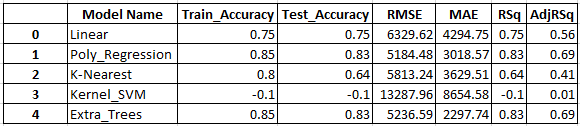

RESULTS: children & region dropped from the dataset

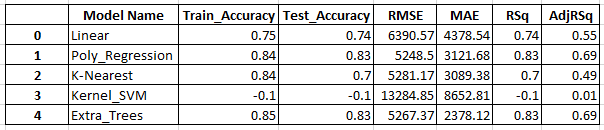


In [1]:
# Import relevant libraries

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.display.width=None

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
# Dataset I/O definitions

PATH = r"C:\DSML_Case_Studies_2021.04.24\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies_2021.04.24\03_Output"
DATASET = r"\Dataset_Insurance_6x1.csv"
PREFIX = r"\Dataset_Insurance_"

#Specify number of features and targets

n_features = 6
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.drop(columns=['children', 'region'])
df = df.round(decimals=4)


collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
df.head()

,age,sex,bmi,smoker,expenses
0,19,female,27.9,yes,16884.92
1,18,male,33.8,no,1725.55
2,28,male,33.0,no,4449.46
3,33,male,22.7,no,21984.47
4,32,male,28.9,no,3866.86


In [6]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [7]:
df.head()

,age,sex,bmi,smoker,expenses
0,19,0,27.9,1,16884.92
1,18,1,33.8,0,1725.55
2,28,1,33.0,0,4449.46
3,33,1,22.7,0,21984.47
4,32,1,28.9,0,3866.86


In [19]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|          |   count |    mean |   std |     min |     25% |     50% |     75% |     max |
|----------|---------|---------|-------|---------|---------|---------|---------|---------|
| age      |    1338 |  39.207 | 14.05 |      18 |      27 |      39 |      51 |      64 |
| sex      |    1338 |   0.505 |   0.5 |       0 |       0 |       1 |       1 |       1 |
| bmi      |    1338 |  30.665 | 6.098 |      16 |    26.3 |    30.4 |    34.7 |    53.1 |
| smoker   |    1338 |   0.205 | 0.404 |       0 |       0 |       0 |       0 |       1 |
| expenses |    1338 | 13270.4 | 12110 | 1121.87 | 4740.29 | 9382.03 | 16639.9 | 63770.4 |


In [9]:
def data_preprocess(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=TESTSIZE, random_state=RND_STATE)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    # Now apply the transformations to the data:
    
    train_scaled = scaler.transform(X_train)
    test_scaled = scaler.transform(X_test)
    y_train=y_train.copy()
    y_test=y_test.copy()
    
    return(train_scaled, test_scaled, y_train, y_test)

In [10]:
# Train Test Split

X_train_sc, X_test_sc, y_train, y_test = data_preprocess(X, y)

In [11]:
# Linear Regression (LR) Model 

from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X_train_sc, y_train)
y_pred = LR.predict(X_test_sc)

TrAcc_LR = round(LR.score(X_train_sc, y_train), 2)
TeAcc_LR = round(LR.score(X_test_sc, y_test), 2)
RMSE_LR = round(np.sqrt(MSE(y_test, y_pred)), 2)
MAE_LR = round(MAE(y_test, y_pred), 2)
RSq_LR = round(r2_score(y_test, y_pred), 2)
AdjRSq_LR = round(1-((1-RSq_LR**2)*((len(X_test_sc)-1)/((X_test_sc.shape[0])-1))), 2)

In [12]:
# Polynomial Regression (PR) Model

from sklearn.preprocessing import PolynomialFeatures

PR = PolynomialFeatures()
X_train_temp = PR.fit_transform(X_train_sc)
X_test_temp = PR.fit_transform(X_test_sc)

# Note: Fit is Polynomial, Model is Sill Linear Regression 

LR_Temp = LinearRegression()
LR_Temp.fit(X_train_temp, y_train)

y_pred = LR_Temp.predict(X_test_temp)

TrAcc_PR = round(LR_Temp.score(X_train_temp, y_train), 2)
TeAcc_PR = round(LR_Temp.score(X_test_temp, y_test), 2)
RMSE_PR = round(np.sqrt(MSE(y_test, y_pred)), 2)
MAE_PR = round(MAE(y_test, y_pred), 2)
RSq_PR = round(r2_score(y_test, y_pred), 2)
AdjRSq_PR = round(1-((1-RSq_PR**2)*((len(X_test_sc)-1)/((X_test_sc.shape[0])-1))), 2)


In [13]:
# K-Nearest Neighbors Regressor (KNNR) Model

from sklearn.neighbors import KNeighborsRegressor

knn_index = []
knn_Tracc = []
knn_Teacc = []
knn_rmse = []
knn_mae = []
knn_rsq = []
knn_adj = []

for k in range(0, 20, 1):
    k = k+1
    KNNM = KNeighborsRegressor(n_neighbors = k)
    KNNM.fit(X_train_sc, y_train)
    y_pred = KNNM.predict(X_test_sc)
    TrAcc_KNNR = round(KNNM.score(X_train_sc, y_train), 2)
    TeAcc_KNNR = round(KNNM.score(X_test_sc, y_test), 2)
    RMSE_KNNR = round(np.sqrt(MSE(y_test, y_pred)), 2)
    MAE_KNNR = round(MAE(y_test, y_pred), 2)
    RSq_KNNR = round(r2_score(y_test, y_pred), 2)
    AdjRSq_KNNR = round(1-((1-RSq_KNNR**2)*((len(X_test_sc)-1)/((X_test_sc.shape[0])-1))), 2)
    knn_index.append(k)
    knn_Tracc.append(TrAcc_KNNR)
    knn_Teacc.append(TeAcc_KNNR)
    knn_rmse.append(RMSE_KNNR)
    knn_mae.append(MAE_KNNR)
    knn_rsq.append(RSq_KNNR)
    knn_adj.append(AdjRSq_KNNR)

K_TrAcc = pd.DataFrame(np.column_stack([knn_index, knn_Tracc]), columns=['K-Neighbors', 'Train_Accuracy'])
K_TeAcc = pd.DataFrame(np.column_stack([knn_index, knn_Teacc]), columns=['K-Neighbors', 'Test_Accuracy'])
K_RMSE = pd.DataFrame(np.column_stack([knn_index, knn_rmse]), columns=['K-Neighbors', 'RMS_Error'])
K_MAE = pd.DataFrame(np.column_stack([knn_index, knn_mae]), columns=['K-Neighbors', 'MA_Error'])
K_RSq = pd.DataFrame(np.column_stack([knn_index, knn_rsq]), columns=['K-Neighbors', 'RSq'])
K_ARSq = pd.DataFrame(np.column_stack([knn_index, knn_adj]), columns=['K-Neighbors', 'Adj_RSq'])

TrAcc_KNNR = K_TrAcc.Train_Accuracy.min()
TeAcc_KNNR = K_TeAcc.Test_Accuracy.min()
RMSE_KNNR = K_RMSE.RMS_Error.min()
MAE_KNNR = K_MAE.MA_Error.min()
RSq_KNNR = K_RSq.RSq.min()
AdjRSq_KNNR = K_ARSq.Adj_RSq.min()

In [14]:
# Kernel Support Vector Regression (KSVR) Model

from sklearn import svm

KSVR = svm.SVR(kernel='poly', degree=4, gamma='auto') # When kernel = poly, define degree
KSVR.fit(X_train_sc, y_train)
y_pred = KSVR.predict(X_test_sc)

TrAcc_KSVR = round(KSVR.score(X_train_sc, y_train), 2)
TeAcc_KSVR = round(KSVR.score(X_test_sc, y_test), 2)
RMSE_KSVR = round(np.sqrt(MSE(y_test, y_pred)), 2)
MAE_KSVR = round(MAE(y_test, y_pred), 2)
RSq_KSVR = round(r2_score(y_test, y_pred), 2)
AdjRSq_KSVR = round(1-((1-RSq_KSVR**2)*((len(X_test_sc)-1)/((X_test_sc.shape[0])-1))), 2)

In [15]:
# Extra Trees Regression (ETR) Model

from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_estimators=200, max_depth=5, criterion='mae', random_state=RND_STATE)
ETR.fit(X_train_sc, y_train)
y_pred = ETR.predict(X_test_sc)

TrAcc_ETR = round(ETR.score(X_train_sc, y_train), 2)
TeAcc_ETR = round(ETR.score(X_test_sc, y_test), 2)
RMSE_ETR = round(np.sqrt(MSE(y_test, y_pred)), 2)
MAE_ETR = round(MAE(y_test, y_pred), 2)
RSq_ETR = round(r2_score(y_test, y_pred), 2)
AdjRSq_ETR = round(1-((1-RSq_ETR**2)*((len(X_test_sc)-1)/((X_test_sc.shape[0])-1))), 2)


In [16]:
modlst = ['Linear', 'Poly_Regression','K-Nearest', 'Kernel_SVM', 'Extra_Trees']
score1 = ['TrAcc_LR', 'TrAcc_PR', 'TrAcc_KNNR', 'TrAcc_KSVR', 'TrAcc_ETR']
score2 = ['TeAcc_LR', 'TeAcc_PR', 'TeAcc_KNNR', 'TeAcc_KSVR', 'TeAcc_ETR']
score3 = ['RMSE_LR', 'RMSE_PR', 'RMSE_KNNR', 'RMSE_KSVR', 'RMSE_ETR']
score4 = ['MAE_LR', 'MAE_PR', 'MAE_KNNR', 'MAE_KSVR', 'MAE_ETR']
score5 = ['RSq_LR', 'RSq_PR', 'RSq_KNNR', 'RSq_KSVR', 'RSq_ETR']
score6 = ['AdjRSq_LR','AdjRSq_PR', 'AdjRSq_KNNR', 'AdjRSq_KSVR', 'AdjRSq_ETR']

tracclst = []
teacclst = []
rmselst = []
maelst = []
rsqlst = []
adjrsqlst = []

for i in range(0, len(score1), 1):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    tracclst.append(var1)
    teacclst.append(var2)
    rmselst.append(var3)
    maelst.append(var4)
    rsqlst.append(var5)
    adjrsqlst.append(var6)

Summary = pd.DataFrame(np.column_stack([modlst, tracclst, teacclst, rmselst, maelst, rsqlst, adjrsqlst]), 
                      columns=['Model Name', 'Train_Accuracy', 'Test_Accuracy', 'RMSE', 'MAE', 'RSq', 'AdjRSq'])

In [17]:
Output = r"MLM_Evaluation.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{Output}", engine='xlsxwriter', options={'strings_to_numbers': True})
Summary.to_excel(writer, sheet_name='Model Evaluation')
writer.save()

In [20]:
!jupyter nbconvert MLM_Dataset_Insurance.ipynb --to html --no-input

[NbConvertApp] Converting notebook MLM_Dataset_Insurance.ipynb to html
[NbConvertApp] Writing 610708 bytes to MLM_Dataset_Insurance.html
